# 🩺 **MAGFLOW**

> Análisis comparativo de los estudios de resonancia de flujo realizados a 20 pacientes con implante de vávlula áortica transcatéter (TAVI).

Este estudio evalúa los siguientes parámetros biomecánicos durante el ciclo cardíaco completo:

- **Flujo volumétrico** (*Q*) - Volumen de sangre por unidad de tiempo [`m³/s`]
- **Velocidad máxima** (*v*<sub>max</sub>) - Velocidad pico en las secciones aórticas [`m/s`]
- **TAWSS** (*Time-Averaged Wall Shear Stress*) - Esfuerzo cortante promedio [`Pa`]
- **OSI** (*Oscillatory Shear Index*) - Índice de oscilación del esfuerzo cortante [`adimensional`]
- **Pérdida de carga** - Disipación de energía en el flujo [`Pa`]
- **Gradientes de presión** - Variación espacial de la presión [`Pa/m`]
- **Vorticidad** - Medida de la rotación local del fluido [`s⁻¹`]
- **Helicidad** - Correlación entre velocidad y vorticidad [`m²/s²`]

## **⚙️ Configuración**

---

Importación e inicialización de bibliotecas y dependencias requeridas para el análisis.

In [ ]:
# Standard library imports
import math
from pathlib import Path

import matplotlib.pyplot as plt

# Third-party imports
import pyvista as pv
from tqdm.notebook import tqdm

import magflow.utils.energy as e
import magflow.utils.flow as f
import magflow.utils.helicity as hel
import magflow.utils.loader as l
import magflow.utils.osi as osi
import magflow.utils.velocity as vel
import magflow.utils.visualization as viz
import magflow.utils.vorticity as vor
import magflow.utils.wss as wss

%matplotlib inline
pv.set_jupyter_backend("static")
pv.global_theme.allow_empty_mesh = True

# Configuration
ASSETS_DIR = Path(r"C:\Users\Luis\Projects\Magflow")
PATIENT_IDS = ["MF033", "MF051"]
DEFAULT_PATIENT = "MF033"  # For single patient analysis
NUM_CENTRELINE_POINTS = 24
CROSS_SECTION_PERCENTAGE = 25

## **🏗️ Carga de datos**

---

Carga e inicialización de todos los conjuntos de datos necesarios para el análisis del flujo aórtico.

Se importan los datos de velocidad del flujo sanguíneo almacenados en formato VTK estructurado (`*.vts`), obtenidos mediante resonancia magnética de flujo 4D. Adicionalmente, se carga la geometría aórtica tridimensional previamente segmentada en *3D Slicer*.

Todos los instantes temporales del ciclo cardíaco se almacenan en un diccionario indexado para facilitar el acceso y procesamiento. El **timestep 85** se utiliza como referencia por defecto, ya que corresponde al pico sistólico donde se alcanza la máxima velocidad del flujo y, por tanto, ofrece el mayor contraste para la visualización.

In [2]:
all_patient_data = {}
all_timesteps = set()

for patient_id in tqdm(PATIENT_IDS, desc="Loading patients"):
    patient_data = l.load_patient(patient_id, ASSETS_DIR, NUM_CENTRELINE_POINTS)

    if patient_data["timesteps"]:
        all_patient_data[patient_id] = patient_data
        all_timesteps.update(patient_data["timesteps"].keys())
    else:
        print(f"Warning: No data loaded for patient {patient_id}")

sorted_timesteps = sorted(all_timesteps)

# Print summary
print("\nDATA LOADING SUMMARY")
print("-" * 30)
print(f"Total patients loaded: {len(all_patient_data)}")
print(f"Unique timesteps across all patients: {len(sorted_timesteps)}")
print(
    f"Timestep range: {min(sorted_timesteps) if sorted_timesteps else 'N/A'} - {max(sorted_timesteps) if sorted_timesteps else 'N/A'}"
)

# Optional: Validate data completeness
print("\nDATA VALIDATION")
print("-" * 20)
for patient_id in PATIENT_IDS:
    if patient_id in all_patient_data:
        validation = l.validate_patient(all_patient_data[patient_id], patient_id)
        print(f"Patient {patient_id}:")
        print(f"  Timesteps: {validation['timestep_count']}")
        print(f"  Biomodel: {'✓' if validation['has_biomodel'] else '✗'}")
        print(f"  Centerline: {'✓' if validation['has_centerline'] else '✗'}")

Loading patients:   0%|          | 0/2 [00:00<?, ?it/s]


DATA LOADING SUMMARY
------------------------------
Total patients loaded: 2
Unique timesteps across all patients: 46
Timestep range: 0 - 793

DATA VALIDATION
--------------------
Patient MF033:
  Timesteps: 24
  Biomodel: ✓
  Centerline: ✓
Patient MF051:
  Timesteps: 24
  Biomodel: ✓
  Centerline: ✓


## **🖼️ Visualización 3D**

---

Representación tridimensional del campo de velocidades del flujo sanguíneo mediante PyVista. Esta visualización muestra la distribución espacial de las velocidades en secciones transversales perpendiculares a la línea central aórtica, permitiendo analizar los patrones de flujo en cada paciente.

La visualización incluye:
- Geometría aórtica tridimensional (biomodelo)
- Línea central aórtica como referencia anatómica
- Campo de velocidades con codificación por colores
- Comparación simultánea entre múltiples pacientes

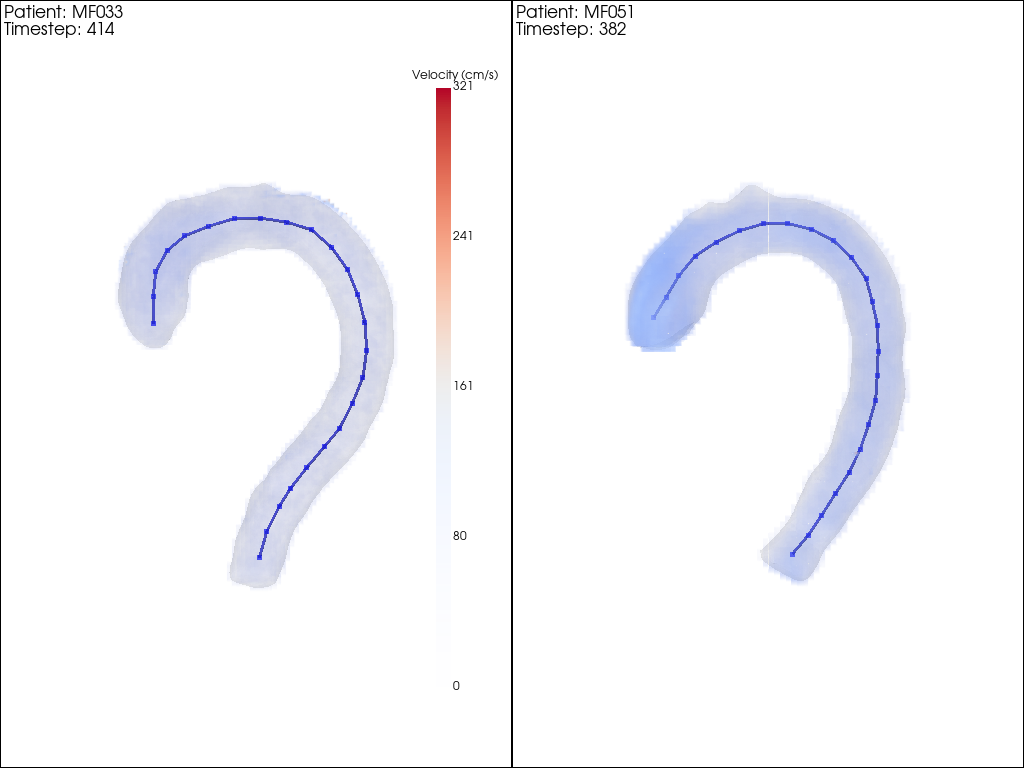

In [3]:
# Setup
n_patients = len(all_patient_data)
n_cols = min(2, n_patients)
n_rows = math.ceil(n_patients / n_cols)

# Find common timestep
selected_ts = 0
plotter = pv.Plotter(shape=(n_rows, n_cols), notebook=True)

# Process each patient
for idx, patient_id in enumerate(PATIENT_IDS):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    # Calculate subplot position
    row = idx // n_cols
    col = idx % n_cols

    # Add patient to subplot
    ts_used = viz.render_patient(
        plotter, patient_id, all_patient_data[patient_id], row, col, selected_ts
    )

# Show the visualization
plotter.show()

## 💧 **Flujo volumétrico**

El flujo volumétrico representa el volumen de sangre que atraviesa una sección transversal de la aorta por unidad de tiempo. Este parámetro hemodinámico fundamental permite evaluar la función cardiovascular y detectar alteraciones en el flujo sanguíneo tras el implante de válvula aórtica transcatéter (TAVI).

El cálculo se basa en la integración del campo de velocidades perpendicular a la superficie de cada sección transversal:

$$
Q = \int_A \vec{v} \cdot \hat{n} \, dA
$$

**Parámetros de la ecuación:**
- *Q* = flujo volumétrico [m³/s]
- $\vec{v}$ = vector velocidad del flujo en cada punto
- $\hat{n}$ = vector normal unitario perpendicular a la sección
- $A$ = área de la sección transversal aórtica

**Metodología de análisis:**

1. **Generación de secciones transversales**: Se crean múltiples planos perpendiculares distribuidos uniformemente a lo largo de la línea central aórtica
2. **Análisis temporal completo**: Los cálculos se ejecutan para cada instante del ciclo cardíaco registrado
3. **Promedio espacial**: Se calcula el valor medio entre todas las secciones para obtener medidas comparables entre pacientes

Calculating flow rates:   0%|          | 0/2 [00:00<?, ?it/s]

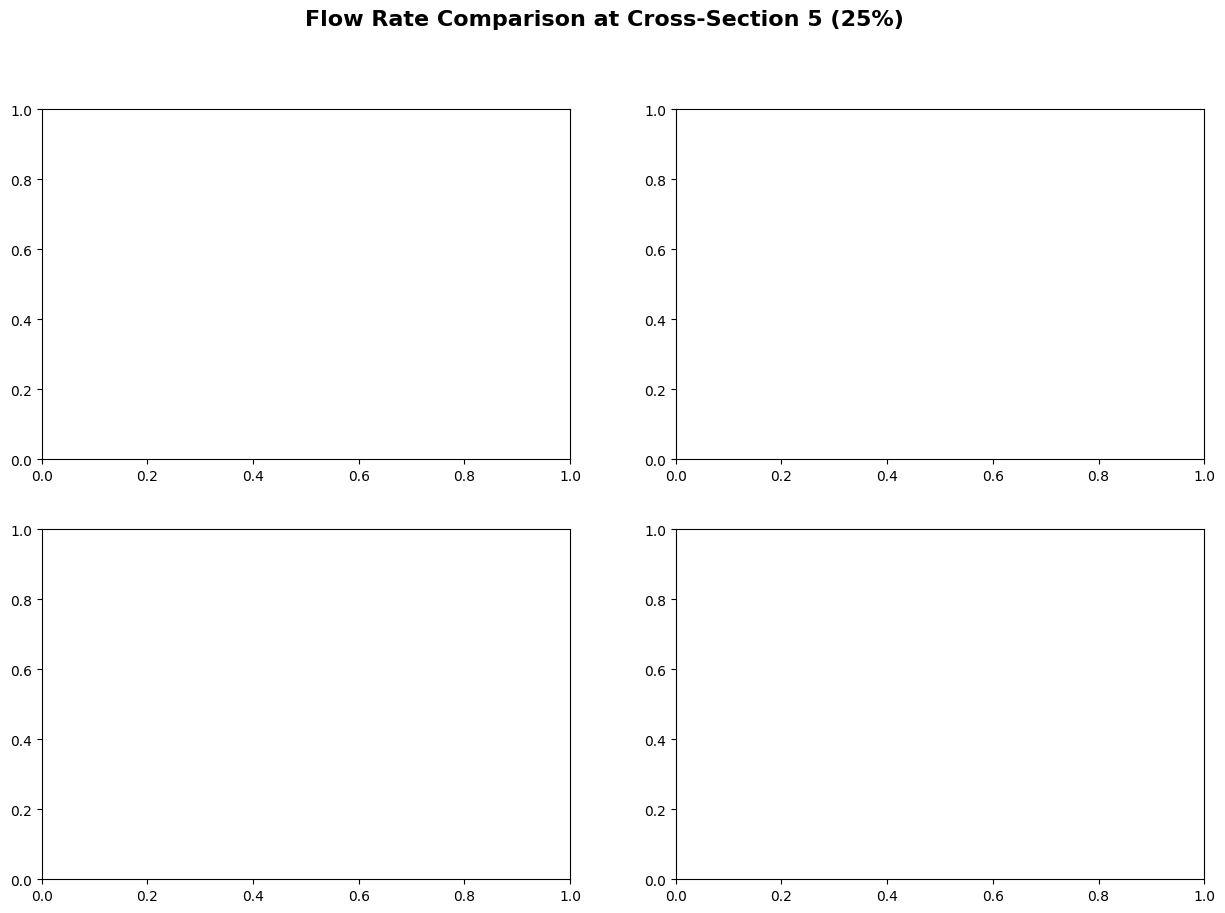

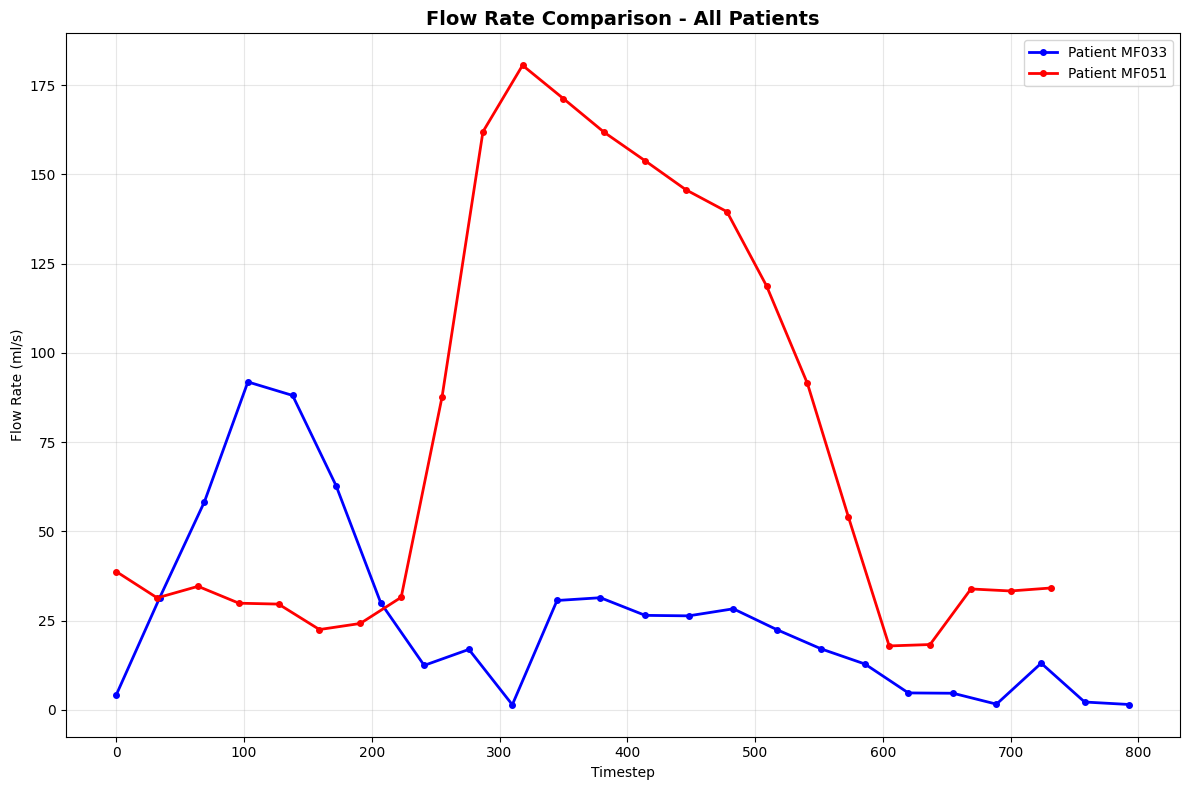

In [4]:
cross_section_index = f.get_cross_section_index(
    CROSS_SECTION_PERCENTAGE, NUM_CENTRELINE_POINTS
)

# Initialize multi-patient flow rates dictionary
all_flow_rates = {}

# Calculate flow rates for all patients
for patient_id in tqdm(PATIENT_IDS, desc="Calculating flow rates"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    # Get patient-specific data
    patient_timesteps = all_patient_data[patient_id]["timesteps"]
    patient_biomodel = all_patient_data[patient_id]["biomodel"]
    patient_centreline = all_patient_data[patient_id]["centerline"].points

    # Calculate the specific point along the centreline for this patient
    selected_centreline_point = patient_centreline[cross_section_index]

    all_flow_rates[patient_id] = f.calculate_flow_rates(
        patient_id,
        patient_timesteps,
        patient_biomodel,
        patient_centreline,
        selected_centreline_point,
    )

# Create multi-patient flow rate comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    f"Flow Rate Comparison at Cross-Section {cross_section_index} ({CROSS_SECTION_PERCENTAGE}%)",
    fontsize=16,
    fontweight="bold",
)

# Flatten axes for easier indexing
axes = axes.flatten()

# Color map for patients
colors = ["blue", "red", "green", "orange"]
patient_colors = dict(zip(PATIENT_IDS, colors, strict=False))

# Create comprehensive comparison plot with overlay of all patients
f.plot_comparison(PATIENT_IDS, all_flow_rates, patient_colors)

# Get comprehensive statistics
flow_rate_statistics = f.get_flow_rate_statistics(all_flow_rates)

## 🚀 **Velocidad máxima**

La velocidad máxima (*v*<sub>max</sub>) representa el valor pico de velocidad del flujo sanguíneo registrado en cada sección transversal aórtica durante el ciclo cardíaco.

**Definición matemática:**

$$
v_{max} = \max(\vec{v} \cdot \hat{n})
$$

Donde:
- *v*<sub>max</sub> = velocidad máxima en la sección [m/s]
- $\vec{v}$ = vector velocidad en cada punto [m/s]
- $\hat{n}$ = vector normal unitario a la sección

**Metodología de cálculo:**

1. **Extracción de velocidades**: Se obtienen las componentes normales de velocidad en cada punto de las secciones transversales
2. **Identificación del máximo**: Se determina el valor pico de velocidad para cada sección y timestep
3. **Análisis temporal**: Se evalúa la evolución de la velocidad máxima a lo largo del ciclo cardíaco

Processing patients:   0%|          | 0/2 [00:00<?, ?it/s]

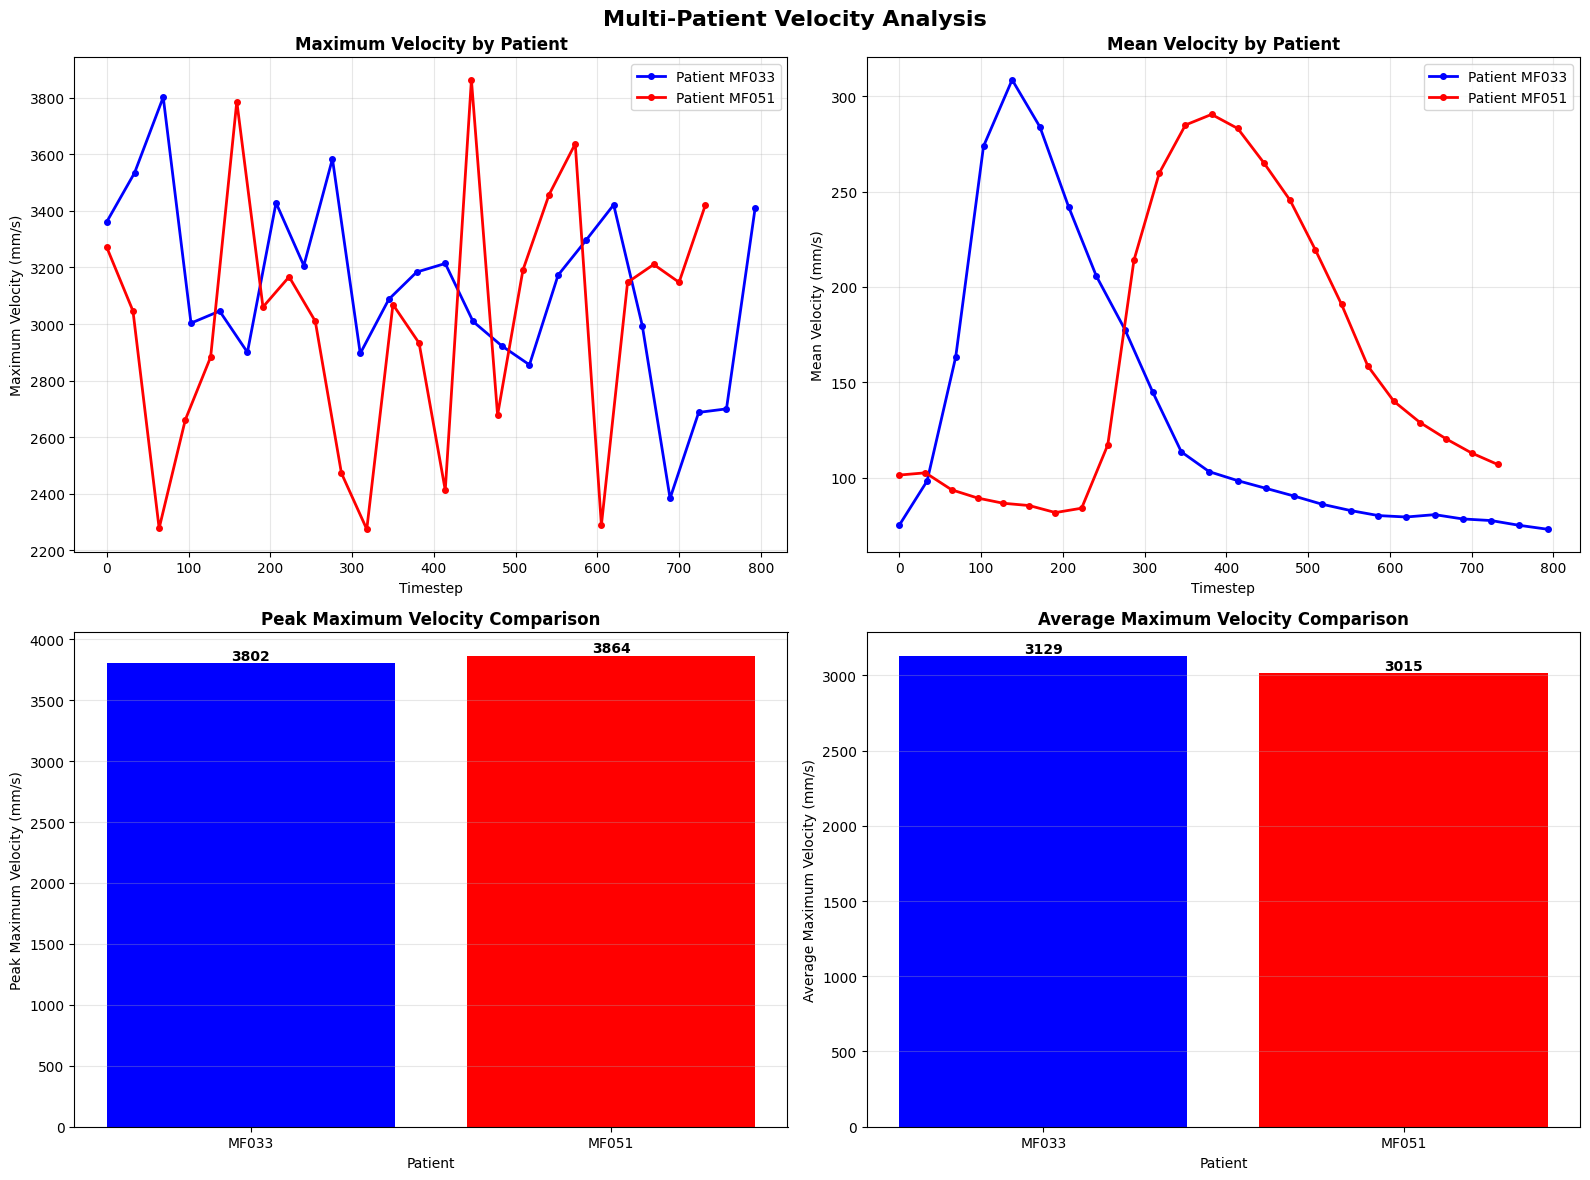

In [5]:
# Multi-patient velocity analysis
all_max_velocities = {}
all_mean_velocities = {}

# Process each patient
for patient_id in tqdm(PATIENT_IDS, desc="Processing patients"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    max_vels, mean_vels = vel.calculate_velocities(
        patient_id, all_patient_data[patient_id]
    )

    all_max_velocities[patient_id] = max_vels
    all_mean_velocities[patient_id] = mean_vels

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Multi-Patient Velocity Analysis", fontsize=16, fontweight="bold")

# Plot 1: Maximum velocities for all patients
vel.plot_velocity_time_series(
    axes[0, 0],
    PATIENT_IDS,
    all_max_velocities,
    patient_colors,
    "Maximum Velocity by Patient",
    "Maximum Velocity (mm/s)",
    "max",
)

# Plot 2: Mean velocities for all patients
vel.plot_velocity_time_series(
    axes[0, 1],
    PATIENT_IDS,
    all_mean_velocities,
    patient_colors,
    "Mean Velocity by Patient",
    "Mean Velocity (mm/s)",
    "mean",
)

# Plot 3: Peak maximum velocity comparison
vel.plot_velocity_comparison_bars(
    axes[1, 0],
    PATIENT_IDS,
    all_max_velocities,
    patient_colors,
    "Peak Maximum Velocity Comparison",
    "Peak Maximum Velocity (mm/s)",
    "peak",
)

# Plot 4: Average maximum velocity comparison
vel.plot_velocity_comparison_bars(
    axes[1, 1],
    PATIENT_IDS,
    all_max_velocities,
    patient_colors,
    "Average Maximum Velocity Comparison",
    "Average Maximum Velocity (mm/s)",
    "average",
)

plt.tight_layout()

# # Calculate and print statistics
# patient_stats, cross_patient_stats = vel.calculate_velocity_statistics(
#     PATIENT_IDS, all_max_velocities, all_mean_velocities
# )

# vel.print_velocity_summary(patient_stats, cross_patient_stats)

## 🌊 **Esfuerzo parietal (WSS)**

El esfuerzo cortante parietal (*Wall Shear Stress*, WSS) representa la tensión tangencial que ejerce el flujo sanguíneo sobre la pared arterial. Este parámetro biomecánico es fundamental para evaluar el riesgo de aterosclerosis y la integridad endotelial post-TAVI.

**Definición matemática:**

Para un flujo cerca de la pared arterial, el WSS se define como:

$$
\tau_w = \mu \left. \frac{\partial u}{\partial n} \right|_{pared}
$$

**Donde:**
- $\tau_w$ = esfuerzo cortante parietal [Pa]
- $\mu$ = viscosidad dinámica de la sangre (≈ 0.004 Pa·s)
- $\frac{\partial u}{\partial n}$ = gradiente de velocidad normal a la pared arterial [s⁻¹]

**Significado clínico:**

- **WSS bajo (< 0.4 Pa)**: Asociado con activación endotelial, inflamación y aterogénesis
- **WSS fisiológico (0.4-1.5 Pa)**: Rango normal que mantiene la función endotelial
- **WSS elevado (> 1.5 Pa)**: Puede indicar estenosis o turbulencia local

**Metodología de cálculo:**

1. **Identificación de la superficie**: Se utiliza la geometría aórtica segmentada como superficie de pared
2. **Cálculo de gradientes**: Se determinan los gradientes de velocidad perpendiculares a la superficie
3. **Análisis temporal**: Se evalúa la evolución del WSS durante todo el ciclo cardíaco

Este análisis permite identificar regiones de riesgo aterosclerótico y evaluar el impacto hemodinámico del implante valvular transcatéter.

Calculating WSS:   0%|          | 0/2 [00:00<?, ?it/s]

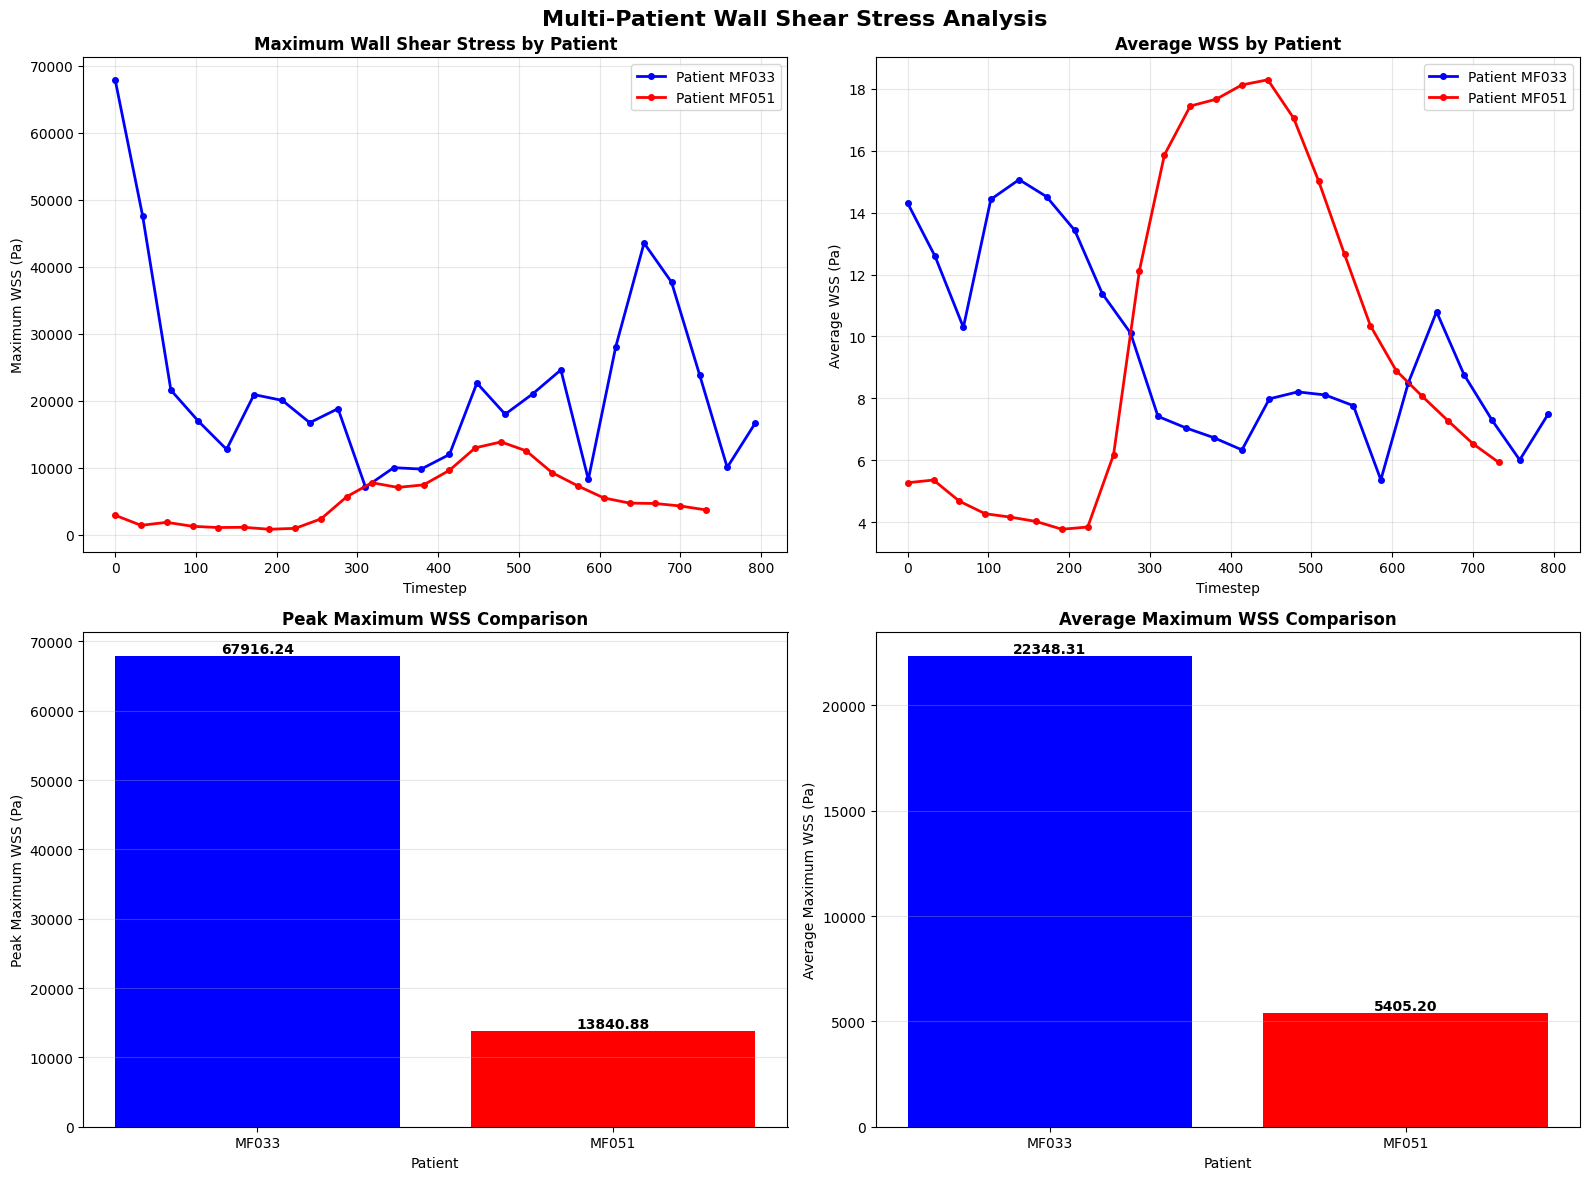

In [6]:
# Parameters
mu = 0.004  # Blood viscosity in Pa·s (typical value)

all_wss_values = {}
all_max_wss_values = {}
all_avg_wss_values = {}

for patient_id in tqdm(PATIENT_IDS, desc="Calculating WSS"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    wss_vals, max_wss_vals, avg_wss_vals = wss.calculate_patient_wss(
        patient_id, all_patient_data[patient_id], mu
    )

    all_wss_values[patient_id] = wss_vals
    all_max_wss_values[patient_id] = max_wss_vals
    all_avg_wss_values[patient_id] = avg_wss_vals

# Main 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Multi-Patient Wall Shear Stress Analysis", fontsize=16, fontweight="bold")

# Plot 1: Maximum WSS time series
wss.plot_wss_time_series(
    axes[0, 0],
    PATIENT_IDS,
    all_max_wss_values,
    patient_colors,
    "Maximum Wall Shear Stress by Patient",
    "Maximum WSS (Pa)",
    "max",
)

# Plot 2: Average WSS time series
wss.plot_wss_time_series(
    axes[0, 1],
    PATIENT_IDS,
    all_avg_wss_values,
    patient_colors,
    "Average WSS by Patient",
    "Average WSS (Pa)",
    "avg",
)

# Plot 3: Peak maximum WSS comparison
wss.plot_wss_comparison_bars(
    axes[1, 0],
    PATIENT_IDS,
    all_max_wss_values,
    patient_colors,
    "Peak Maximum WSS Comparison",
    "Peak Maximum WSS (Pa)",
    "peak",
)

# Plot 4: Average maximum WSS comparison
wss.plot_wss_comparison_bars(
    axes[1, 1],
    PATIENT_IDS,
    all_max_wss_values,
    patient_colors,
    "Average Maximum WSS Comparison",
    "Average Maximum WSS (Pa)",
    "average",
)

plt.tight_layout()
plt.show()

# # Calculate and print statistics
# patient_stats, cross_patient_stats = wss.calculate_wss_statistics(
#     PATIENT_IDS, all_max_wss_values, all_avg_wss_values
# )

# wss.print_wss_summary(patient_stats, cross_patient_stats)

## 🔄 **Índice oscilatorio (OSI)**

El Índice de Esfuerzo Cortante Oscilatorio (*Oscillatory Shear Index*, OSI) cuantifica la variabilidad direccional del esfuerzo cortante parietal durante el ciclo cardíaco. Este parámetro es fundamental para identificar regiones con riesgo elevado de aterogénesis y disfunción endotelial.

**Definición matemática:**

$$
OSI = \frac{1}{2} \left( 1 - \frac{\left| \int_0^T \vec{\tau_w} \, dt \right|}{\int_0^T \left| \vec{\tau_w} \right| \, dt} \right)
$$

**Donde:**
- *OSI* = índice de esfuerzo cortante oscilatorio [adimensional]
- $\vec{\tau_w}$ = vector de esfuerzo cortante parietal [Pa]
- *T* = período del ciclo cardíaco [s]

**Interpretación clínica:**

- **OSI ≈ 0**: Flujo unidireccional estable, condiciones hemodinámicas favorables
- **OSI ≈ 0.5**: Flujo altamente oscilatorio, riesgo aterogénico máximo
- **OSI > 0.2**: Umbral asociado con activación endotelial y formación de placas

**Significado biomecánico:**

El OSI evalúa la relación entre el esfuerzo cortante vectorial promedio y su magnitud promedio. Valores altos indican cambios frecuentes en la dirección del flujo, creando un ambiente proaterogénico que favorece la disfunción endotelial, la inflamación local y el desarrollo de aterosclerosis.

Este análisis es particularmente relevante en pacientes post-TAVI para evaluar las alteraciones hemodinámicas inducidas por el implante valvular y su potencial impacto en la progresión de la enfermedad cardiovascular.

Calculating OSI:   0%|          | 0/2 [00:00<?, ?it/s]

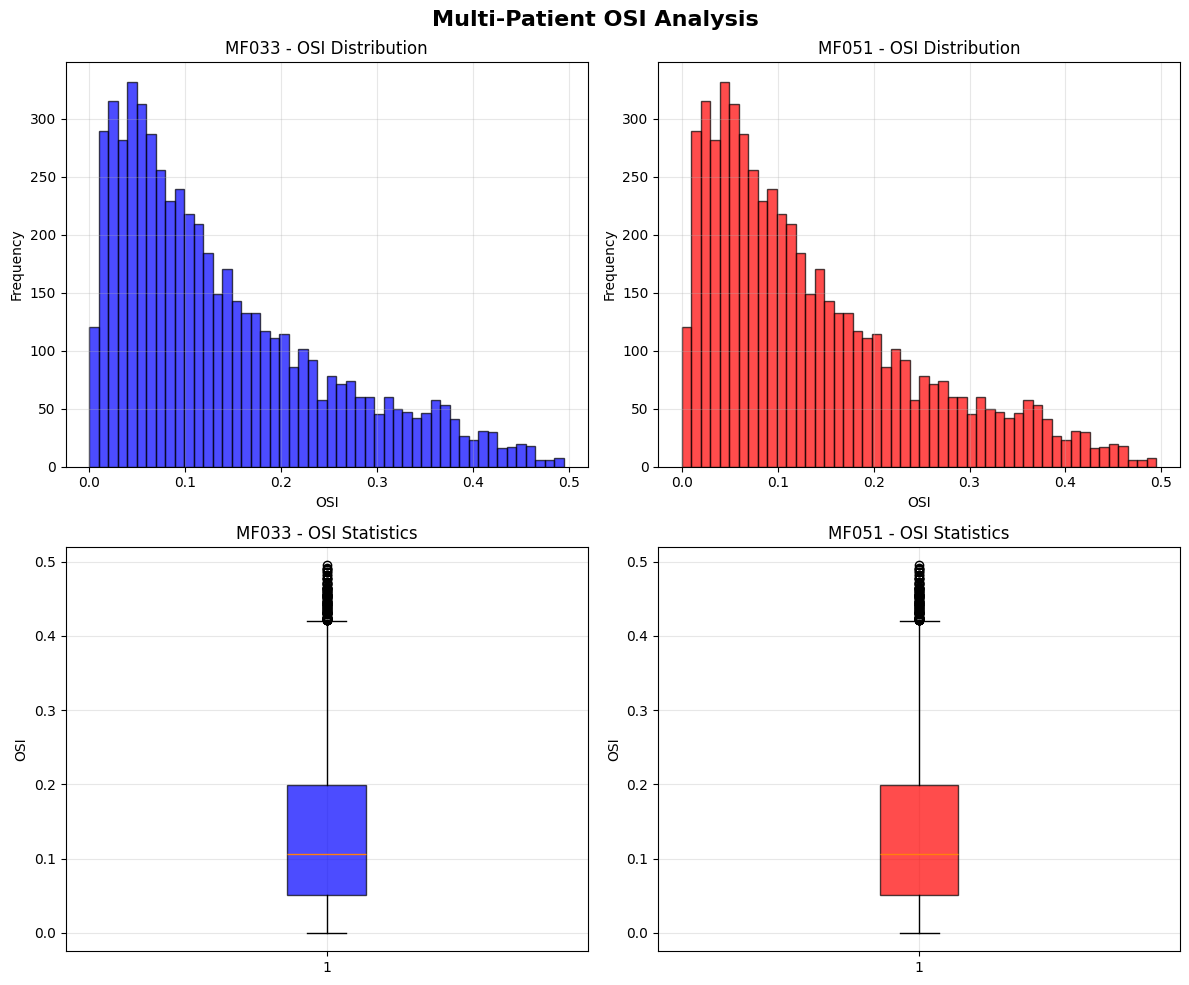


OSI ANALYSIS SUMMARY
--------------------------------------------------

Patient MF033:
  Mean OSI: 0.1384
  Median OSI: 0.1063
  Max OSI: 0.4948
  Min non-zero OSI: 0.0010
  Points with OSI > 0.2: 1401 (24.8%)

Patient MF051:
  Mean OSI: 0.1384
  Median OSI: 0.1063
  Max OSI: 0.4948
  Min non-zero OSI: 0.0010
  Points with OSI > 0.2: 1401 (24.8%)

CROSS-PATIENT COMPARISON
------------------------------
Overall mean OSI range: 0.1384 - 0.1384
Overall max OSI range: 0.4948 - 0.4948


In [7]:
# Calculate OSI for all patients
all_osi_values = {}

for patient_id in tqdm(PATIENT_IDS, desc="Calculating OSI"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    patient_timesteps = list(patient_data["timesteps"].keys())
    patient_timestep_data = patient_data["timesteps"]
    patient_biomodel = patient_data["biomodel"]

    osi_values = osi.calculate_osi(
        patient_timesteps, patient_timestep_data, patient_biomodel, mu
    )

    all_osi_values[patient_id] = osi_values

# Create visualization
fig, axes = plt.subplots(2, len(PATIENT_IDS), figsize=(6 * len(PATIENT_IDS), 10))
if len(PATIENT_IDS) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle("Multi-Patient OSI Analysis", fontsize=16, fontweight="bold")

for idx, patient_id in enumerate(PATIENT_IDS):
    if patient_id in all_osi_values:
        osi_values = all_osi_values[patient_id]

        # Histogram of OSI values
        axes[0, idx].hist(
            osi_values,
            bins=50,
            color=patient_colors[patient_id],
            alpha=0.7,
            edgecolor="black",
        )
        axes[0, idx].set_title(f"{patient_id} - OSI Distribution")
        axes[0, idx].set_xlabel("OSI")
        axes[0, idx].set_ylabel("Frequency")
        axes[0, idx].grid(True, alpha=0.3)

        # Box plot of OSI values
        axes[1, idx].boxplot(
            osi_values,
            patch_artist=True,
            boxprops={"facecolor": patient_colors[patient_id], "alpha": 0.7},
        )
        axes[1, idx].set_title(f"{patient_id} - OSI Statistics")
        axes[1, idx].set_ylabel("OSI")
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print statistics
patient_stats, cross_patient_stats = osi.calculate_osi_statistics(
    PATIENT_IDS, all_osi_values
)
osi.print_osi_summary(patient_stats, cross_patient_stats)

## ⚡ **Pérdida de energía viscosa**

La pérdida de energía viscosa (*Viscous Energy Loss*, VEL) cuantifica la disipación de energía mecánica del flujo sanguíneo debido a las fuerzas viscosas. Este parámetro es fundamental para evaluar la eficiencia hemodinámica y detectar anomalías en el flujo post-TAVI.

**Definición matemática:**

Para un fluido newtoniano incompresable, la función de disipación viscosa se define mediante el tensor de deformación:

$$
\Phi = \mu \sum_{i,j} \left( \frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i} \right)^2 = 2\mu \sum_{i,j} S_{ij}^2
$$

**Donde:**
- $\Phi$ = función de disipación viscosa [W/m³]
- $\mu$ = viscosidad dinámica de la sangre (≈ 0.004 Pa·s)
- $u_i$ = componentes de velocidad [m/s]
- $x_j$ = coordenadas espaciales [m]
- $S_{ij}$ = tensor de deformación simétrico [s⁻¹]

**Pérdida total de energía:**

La pérdida total se obtiene integrando la función de disipación sobre todo el volumen aórtico:

$$
E_{loss} = \int_V \Phi \, dV \quad [W]
$$

**Significado clínico:**

La VEL proporciona información sobre:
- **Eficiencia energética** del flujo sanguíneo
- **Presencia de turbulencias** locales
- **Impacto hemodinámico** del implante TAVI
- **Pérdidas de carga** en el sistema cardiovascular

Este análisis permite evaluar la calidad hemodinámica post-intervención y detectar regiones con disipación energética elevada que pueden comprometer la función cardiovascular.

Processing patients:   0%|          | 0/2 [00:00<?, ?it/s]


VISCOUS ENERGY LOSS SUMMARY - ALL PATIENTS

Patient MF033:
--------------------
Peak energy loss: 4137513.99 mW
Mean energy loss: 1913163.57 mW
Minimum energy loss: 1022322.09 mW
Peak occurs at timestep: 138
Total energy per cycle: 1868.7129 J
Energy efficiency ratio: 0.247
Flow rate correlation: 0.672
Correlation strength: moderate

Patient MF051:
--------------------
Peak energy loss: 1623551.36 mW
Mean energy loss: 890432.91 mW
Minimum energy loss: 425502.03 mW
Peak occurs at timestep: 382
Total energy per cycle: 860.6915 J
Energy efficiency ratio: 0.262
Flow rate correlation: 0.798
Correlation strength: strong

CROSS-PATIENT COMPARISON
------------------------------
Highest peak energy loss: 4137513.99 mW (MF033)
Lowest peak energy loss: 1623551.36 mW (MF051)
Highest mean energy loss: 1913163.57 mW (MF033)
Lowest mean energy loss: 890432.91 mW (MF051)

Overall statistics:
Average peak energy loss across patients: 2880532.68 mW
Average mean energy loss across patients: 1401798.24 m

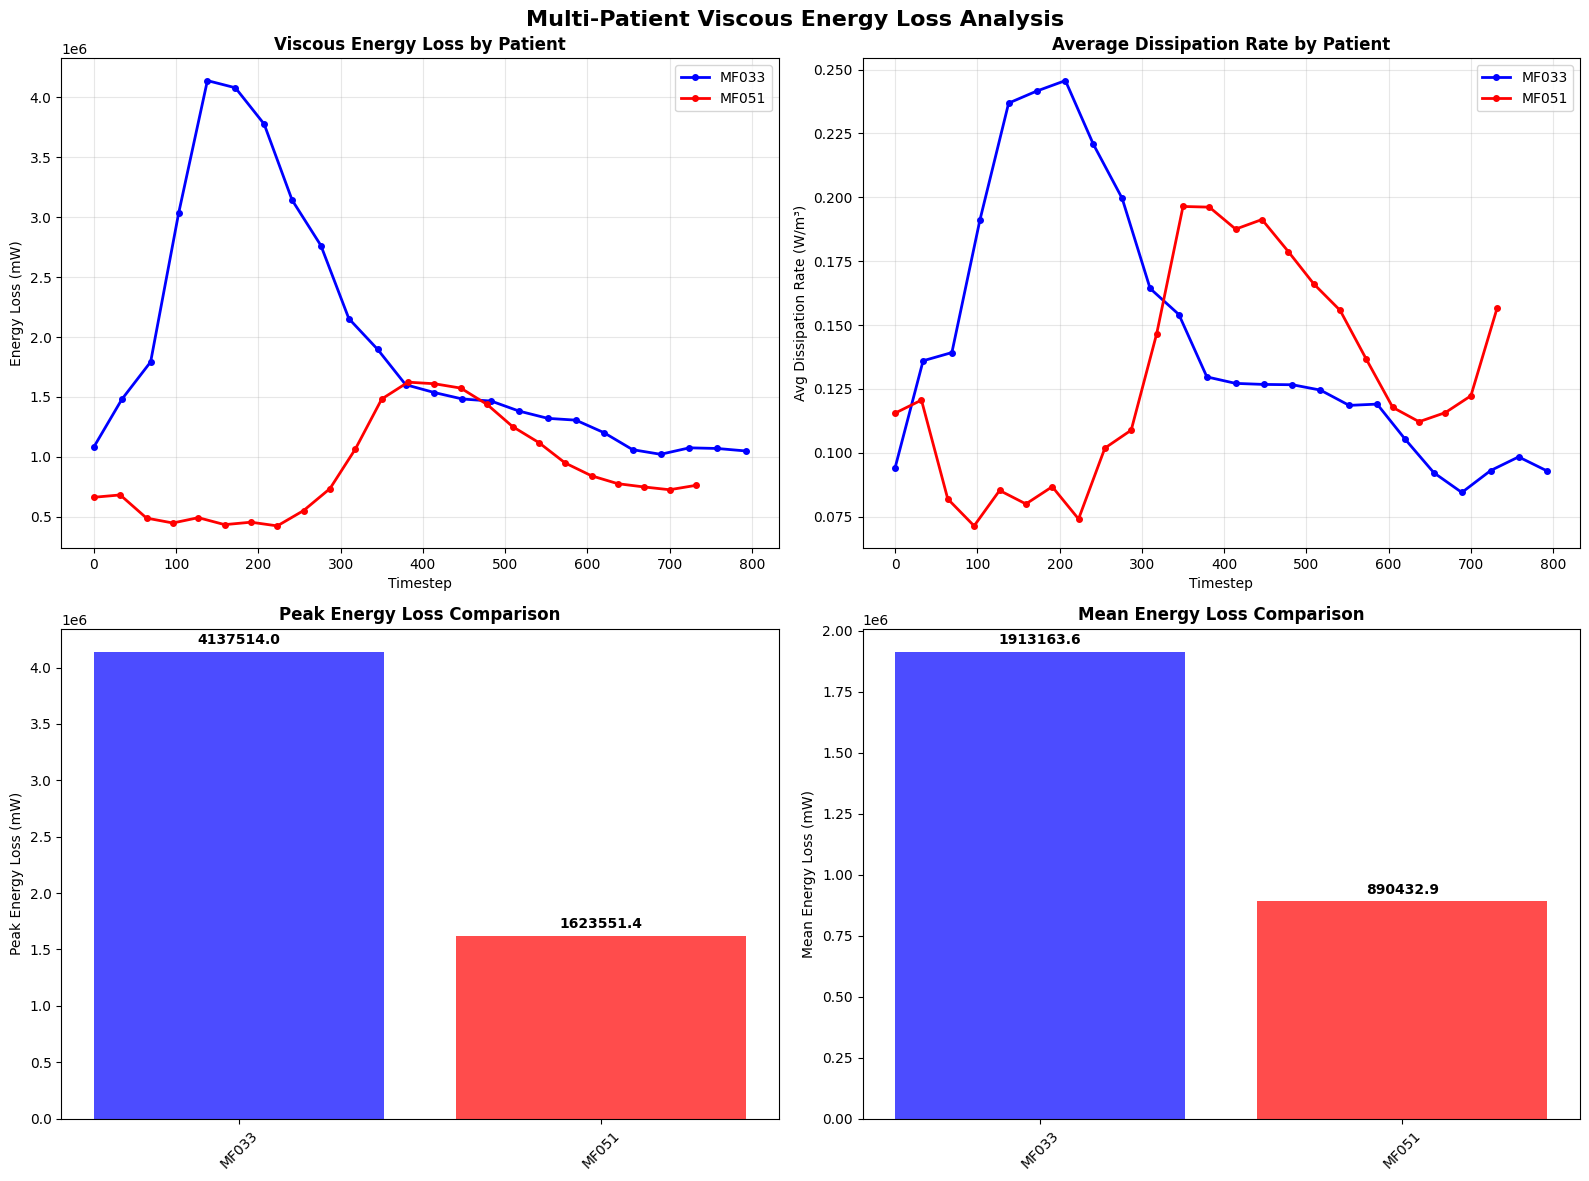

In [8]:
# Parameters for viscous energy loss calculation
mu = 0.004  # Blood viscosity in Pa·s (typical value)

# Calculate viscous energy loss for all patients
all_viscous_energy_loss = {}
all_total_dissipation = {}
all_avg_dissipation_rate = {}

# Process each patient
for patient_id in tqdm(PATIENT_IDS, desc="Processing patients"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    # Get patient-specific data
    patient_data = all_patient_data[patient_id]
    patient_timesteps = list(patient_data["timesteps"].keys())
    patient_timestep_data = patient_data["timesteps"]
    patient_biomodel = patient_data["biomodel"]

    # Calculate energy loss for this patient
    energy_loss, total_diss, avg_diss = e.calculate_patient_energy_loss(
        patient_timesteps, patient_timestep_data, patient_biomodel, mu
    )

    # Store patient results in main dictionaries
    all_viscous_energy_loss[patient_id] = energy_loss
    all_total_dissipation[patient_id] = total_diss
    all_avg_dissipation_rate[patient_id] = avg_diss

# Create main 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    "Multi-Patient Viscous Energy Loss Analysis", fontsize=16, fontweight="bold"
)

# Plot 1: Energy loss time series
e.plot_energy_loss_time_series(
    axes[0, 0], PATIENT_IDS, all_viscous_energy_loss, patient_colors
)

# Plot 2: Average dissipation rate time series
e.plot_dissipation_rate_time_series(
    axes[0, 1], PATIENT_IDS, all_avg_dissipation_rate, patient_colors
)

# Plot 3: Peak energy loss comparison
peak_energies = e.calculate_peak_energies(PATIENT_IDS, all_viscous_energy_loss)
e.plot_energy_comparison_bars(
    axes[1, 0],
    PATIENT_IDS,
    peak_energies,
    patient_colors,
    "Peak Energy Loss Comparison",
    "Peak Energy Loss (mW)",
)

# Plot 4: Mean energy loss comparison
mean_energies = e.calculate_mean_energies(PATIENT_IDS, all_viscous_energy_loss)
e.plot_energy_comparison_bars(
    axes[1, 1],
    PATIENT_IDS,
    mean_energies,
    patient_colors,
    "Mean Energy Loss Comparison",
    "Mean Energy Loss (mW)",
)

plt.tight_layout()

# Calculate comprehensive statistics
patient_statistics = e.calculate_energy_statistics(
    PATIENT_IDS, all_viscous_energy_loss, all_flow_rates
)

# Print summary
e.print_energy_analysis_summary(
    PATIENT_IDS, patient_statistics, all_viscous_energy_loss
)

## 🌪️ **Vorticidad**

La vorticidad ($\omega$) es una medida de la rotación local del fluido en cada punto del campo de velocidades. Este parámetro biomecánico es fundamental para identificar estructuras de flujo complejas como vórtices, remolinos y zonas de recirculación en el flujo sanguíneo aórtico.

**Definición matemática:**

La vorticidad se define como el rotacional (curl) del campo de velocidades:

$$
\vec{\omega} = \nabla \times \vec{v} = \begin{vmatrix}
\hat{i} & \hat{j} & \hat{k} \\
\frac{\partial}{\partial x} & \frac{\partial}{\partial y} & \frac{\partial}{\partial z} \\
v_x & v_y & v_z
\end{vmatrix}
$$

**Componentes de la vorticidad:**

$$
\omega_x = \frac{\partial v_z}{\partial y} - \frac{\partial v_y}{\partial z}
$$

$$
\omega_y = \frac{\partial v_x}{\partial z} - \frac{\partial v_z}{\partial x}
$$

$$
\omega_z = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

**Magnitud de la vorticidad:**

$$
|\vec{\omega}| = \sqrt{\omega_x^2 + \omega_y^2 + \omega_z^2}
$$

**Donde:**
- $\vec{\omega}$ = vector vorticidad [s⁻¹]
- $\vec{v}$ = vector velocidad [m/s]
- $v_x, v_y, v_z$ = componentes de velocidad [m/s]

**Significado físico:**

La vorticidad representa la tendencia de las partículas de fluido a rotar alrededor de un eje instantáneo. En el contexto del flujo aórtico post-TAVI:

- **Vorticidad baja (< 50 s⁻¹)**: Flujo laminar ordenado, condiciones hemodinámicas óptimas
- **Vorticidad moderada (50-200 s⁻¹)**: Transición hacia flujo turbulento, estructuras de vórtice
- **Vorticidad alta (> 200 s⁻¹)**: Flujo altamente turbulento, posible disfunción valvular

**Interpretación clínica:**

La presencia de alta vorticidad en regiones específicas puede indicar:
- **Estenosis residual** o mal funcionamiento de la válvula TAVI
- **Formación de vórtices** que pueden favorecer la hemólisis
- **Turbulencia excesiva** asociada con pérdidas energéticas
- **Zonas de estasis** propensas a la formación de trombos

Este análisis permite evaluar la calidad hemodinámica post-TAVI y detectar patrones de flujo anómalos que requieren seguimiento clínico.

Processing patients:   0%|          | 0/2 [00:00<?, ?it/s]

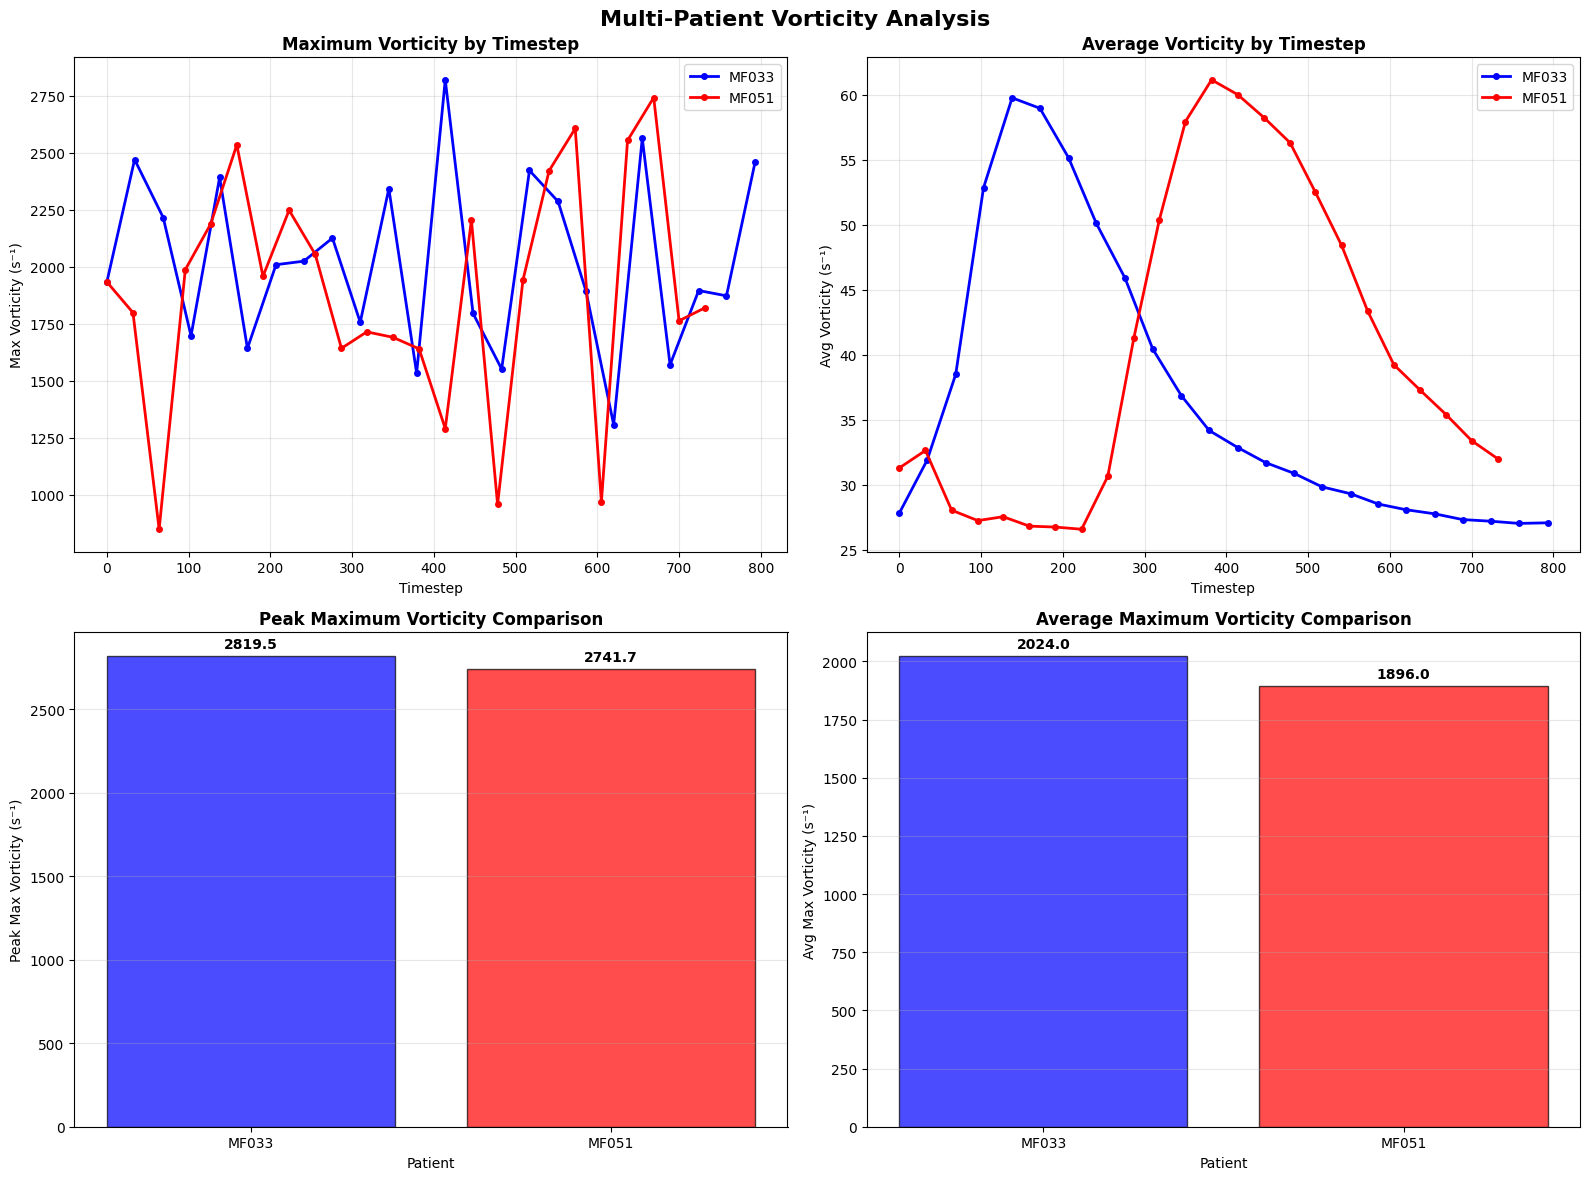


MULTI-PATIENT VORTICITY ANALYSIS SUMMARY

PATIENT MF033
--------------------
Peak maximum vorticity: 2819.5 s⁻¹
Mean maximum vorticity: 2024.0 s⁻¹
Minimum maximum vorticity: 1307.8 s⁻¹
Peak occurs at timestep: 414
Peak average vorticity: 59.8 s⁻¹
Mean average vorticity: 36.7 s⁻¹
Flow rate correlation: 0.038
Correlation strength: weak

PATIENT MF051
--------------------
Peak maximum vorticity: 2741.7 s⁻¹
Mean maximum vorticity: 1896.0 s⁻¹
Minimum maximum vorticity: 849.2 s⁻¹
Peak occurs at timestep: 669
Peak average vorticity: 61.1 s⁻¹
Mean average vorticity: 40.2 s⁻¹
Flow rate correlation: -0.293
Correlation strength: weak

CROSS-PATIENT COMPARISON
------------------------------
Highest peak vorticity across patients: 2819.5 s⁻¹
Lowest peak vorticity across patients: 2741.7 s⁻¹
Mean peak vorticity across patients: 2780.6 s⁻¹
Standard deviation of peak vorticity: 38.9 s⁻¹


In [9]:
# Calculate multi-patient vorticity
all_vorticity_data = {}
all_vorticity_magnitude = {}
all_max_vorticity = {}
all_avg_vorticity = {}

for patient_id in tqdm(PATIENT_IDS, desc="Processing patients"):
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        continue

    # Calculate vorticity for single patient
    vort_data, vort_mag, max_vort, avg_vort = vor.calculate_patient_vorticity(
        patient_id, all_patient_data[patient_id]
    )

    # Store results
    all_vorticity_data[patient_id] = vort_data
    all_vorticity_magnitude[patient_id] = vort_mag
    all_max_vorticity[patient_id] = max_vort
    all_avg_vorticity[patient_id] = avg_vort

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Multi-Patient Vorticity Analysis", fontsize=16, fontweight="bold")

# Plot 1: Maximum vorticity time series
vor.plot_vorticity_time_series(
    axes[0, 0],
    PATIENT_IDS,
    all_max_vorticity,
    patient_colors,
    "Maximum Vorticity by Timestep",
    "Max Vorticity (s⁻¹)",
)

# Plot 2: Average vorticity time series
vor.plot_vorticity_time_series(
    axes[0, 1],
    PATIENT_IDS,
    all_avg_vorticity,
    patient_colors,
    "Average Vorticity by Timestep",
    "Avg Vorticity (s⁻¹)",
)

# Plot 3: Peak maximum vorticity comparison
peak_values = vor.calculate_peak_vorticity_by_patient(PATIENT_IDS, all_max_vorticity)
vor.plot_vorticity_comparison_bars(
    axes[1, 0],
    peak_values,
    patient_colors,
    "Peak Maximum Vorticity Comparison",
    "Peak Max Vorticity (s⁻¹)",
)

# Plot 4: Average maximum vorticity comparison
avg_values = vor.calculate_average_vorticity_by_patient(PATIENT_IDS, all_max_vorticity)
vor.plot_vorticity_comparison_bars(
    axes[1, 1],
    avg_values,
    patient_colors,
    "Average Maximum Vorticity Comparison",
    "Avg Max Vorticity (s⁻¹)",
)

plt.tight_layout()
plt.show()

# Calculate and print statistics
patient_stats, cross_patient_stats = vor.calculate_vorticity_statistics(
    PATIENT_IDS, all_max_vorticity, all_avg_vorticity, all_flow_rates
)

vor.print_vorticity_summary(patient_stats, cross_patient_stats)

## 🌀 **Helicidad**

La helicidad (*H*) es un invariante topológico que cuantifica la correlación entre el campo de velocidades y su vorticidad asociada. Este parámetro biomecánico avanzado caracteriza la naturaleza helicoidal del flujo sanguíneo y es fundamental para identificar estructuras de flujo tridimensionales complejas en el sistema cardiovascular post-TAVI.

**Definición matemática:**

La helicidad se define como el producto escalar entre el vector velocidad y el vector vorticidad:

$$
H = \vec{v} \cdot \vec{\omega} = \vec{v} \cdot (\nabla \times \vec{v})
$$

**Donde:**
- *H* = helicidad local [m²/s²]
- $\vec{v}$ = vector velocidad del flujo [m/s]
- $\vec{\omega}$ = vector vorticidad [s⁻¹]

**Helicidad volumétrica integrada:**

Para caracterizar el comportamiento global del flujo aórtico, se calcula la helicidad total:

$$
H_{total} = \int_V \vec{v} \cdot \vec{\omega} \, dV
$$

**Interpretación física:**

La helicidad proporciona información sobre la topología tridimensional del flujo:

- **H > 0**: Flujo helicoidal dextrógiro (rotación en sentido horario vista desde la dirección del flujo)
- **H < 0**: Flujo helicoidal levógiro (rotación en sentido antihorario)
- **H ≈ 0**: Flujo bidimensional o ausencia de correlación velocidad-vorticidad

**Significado biomecánico:**

En el contexto del flujo aórtico, la helicidad revela:

- **Estructuras helicoidales**: Vórtices tubulares y flujos en espiral característicos del flujo fisiológico
- **Complejidad topológica**: Grado de tridimensionalidad y organización espacial del flujo
- **Eficiencia energética**: Los flujos helicoidales pueden ser más eficientes energéticamente que los turbulentos
- **Estabilidad del flujo**: Las estructuras helicoidales tienden a ser más estables que los vórtices planares

**Relevancia clínica post-TAVI:**

La alteración de los patrones helicoidales naturales puede indicar:

- **Disfunción valvular**: Cambios en la geometría helicoidal normal del flujo aórtico
- **Turbulencia patológica**: Pérdida de la organización helicoidal del flujo
- **Riesgo trombótico**: Regiones con helicidad anómala pueden favorecer la agregación plaquetaria
- **Eficiencia hemodinámica**: Evaluación de la preservación de patrones de flujo fisiológicos

**Metodología de análisis:**

1. **Cálculo de vorticidad**: Se determina el rotacional del campo de velocidades en cada punto
2. **Producto escalar**: Se calcula la correlación local entre velocidad y vorticidad
3. **Análisis estadístico**: Se evalúan valores máximos, promedios y distribuciones espaciales
4. **Evolución temporal**: Se analiza la variación de la helicidad durante el ciclo cardíaco

Este análisis permite evaluar la preservación de la arquitectura helicoidal natural del flujo aórtico tras el implante TAVI y detectar alteraciones topológicas que puedan comprometer la función cardiovascular.

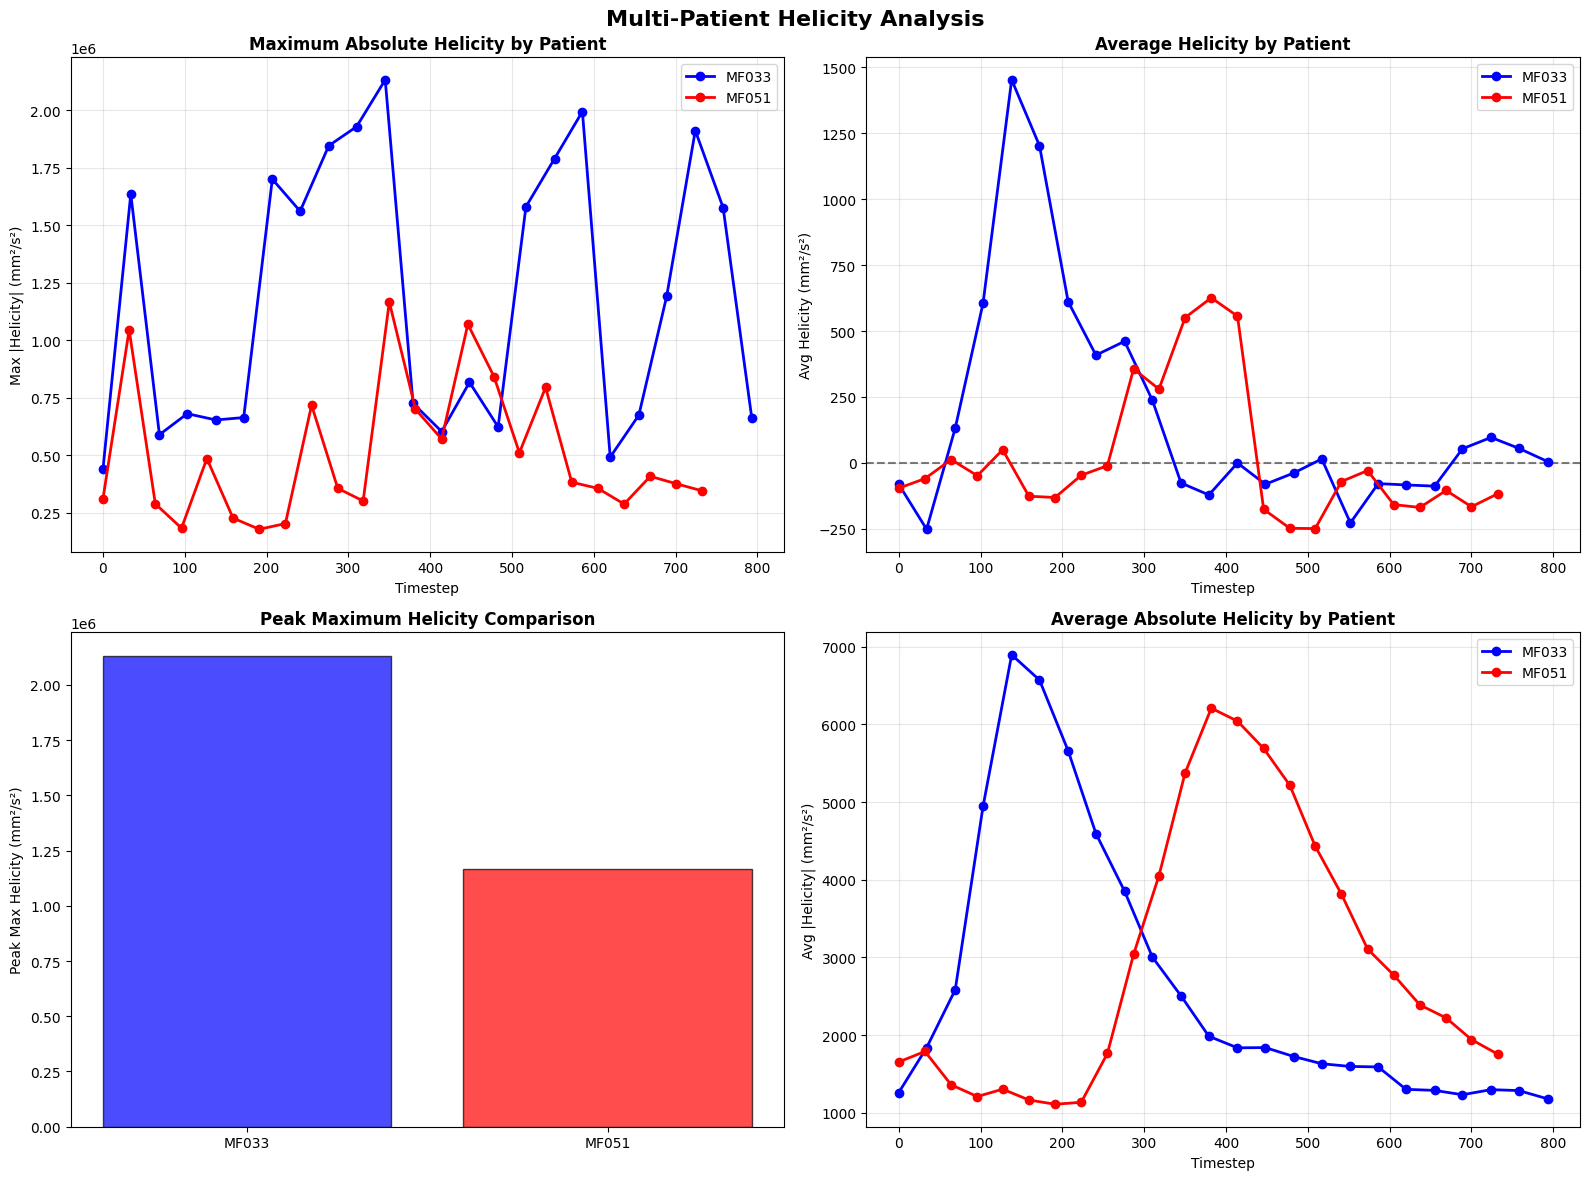


MULTI-PATIENT HELICITY ANALYSIS SUMMARY

Patient MF033:
------------------------------
Peak maximum helicity: 2131373.5 mm²/s²
Mean maximum helicity: 1186426.9 mm²/s²
Minimum maximum helicity: 440600.6 mm²/s²
Peak occurs at timestep: 345
Peak average helicity: 1452.9 mm²/s²
Minimum average helicity: -251.6 mm²/s²
Mean average helicity: 175.5 mm²/s²
Peak average absolute helicity: 6897.2 mm²/s²
Mean average absolute helicity: 2645.0 mm²/s²
Flow rate correlation (max helicity): -0.317
Flow rate correlation strength: moderate
Vorticity correlation (max helicity): 0.123

Patient MF051:
------------------------------
Peak maximum helicity: 1166394.6 mm²/s²
Mean maximum helicity: 505234.8 mm²/s²
Minimum maximum helicity: 179359.6 mm²/s²
Peak occurs at timestep: 350
Peak average helicity: 626.2 mm²/s²
Minimum average helicity: -249.0 mm²/s²
Mean average helicity: 17.8 mm²/s²
Peak average absolute helicity: 6209.4 mm²/s²
Mean average absolute helicity: 2939.0 mm²/s²
Flow rate correlation (max

In [10]:
# Calculate helicity for all patients
all_helicity_data = {}
all_helicity_magnitude = {}
all_max_helicity = {}
all_avg_helicity = {}
all_abs_avg_helicity = {}

for patient_id in PATIENT_IDS:
    if patient_id not in all_patient_data:
        print(f"Warning: No data found for patient {patient_id}")
        # Initialize empty dictionaries for missing patients
        all_helicity_data[patient_id] = {}
        all_helicity_magnitude[patient_id] = {}
        all_max_helicity[patient_id] = {}
        all_avg_helicity[patient_id] = {}
        all_abs_avg_helicity[patient_id] = {}
        continue

    patient_data = all_patient_data[patient_id]
    patient_vorticity_data = all_vorticity_data[patient_id]

    hel_data, hel_mag, max_hel, avg_hel, abs_avg_hel = hel.calculate_patient_helicity(
        patient_id, patient_data, patient_vorticity_data
    )

    all_helicity_data[patient_id] = hel_data
    all_helicity_magnitude[patient_id] = hel_mag
    all_max_helicity[patient_id] = max_hel
    all_avg_helicity[patient_id] = avg_hel
    all_abs_avg_helicity[patient_id] = abs_avg_hel

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Multi-Patient Helicity Analysis", fontsize=16, fontweight="bold")

# Plot 1: Maximum absolute helicity time series
hel.plot_helicity_time_series(
    axes[0, 0],
    PATIENT_IDS,
    all_max_helicity,
    patient_colors,
    "Maximum Absolute Helicity by Patient",
    "Max |Helicity| (mm²/s²)",
)

# Plot 2: Average helicity time series
hel.plot_helicity_time_series(
    axes[0, 1],
    PATIENT_IDS,
    all_avg_helicity,
    patient_colors,
    "Average Helicity by Patient",
    "Avg Helicity (mm²/s²)",
    add_zero_line=True,
)

# Plot 3: Peak maximum helicity comparison
hel.plot_helicity_comparison_bars(
    axes[1, 0],
    PATIENT_IDS,
    all_max_helicity,
    patient_colors,
    "Peak Maximum Helicity Comparison",
    "Peak Max Helicity (mm²/s²)",
)

# Plot 4: Average absolute helicity time series
hel.plot_helicity_time_series(
    axes[1, 1],
    PATIENT_IDS,
    all_abs_avg_helicity,
    patient_colors,
    "Average Absolute Helicity by Patient",
    "Avg |Helicity| (mm²/s²)",
)

plt.tight_layout()
plt.show()

# Calculate and print statistics
patient_stats = hel.calculate_helicity_statistics(
    PATIENT_IDS, all_max_helicity, all_avg_helicity, all_abs_avg_helicity
)

hel.print_helicity_summary(
    PATIENT_IDS, patient_stats, all_max_helicity, all_flow_rates, all_max_vorticity
)